# Monte Carlo Policy Evaluation on BlackJack

In this notebook, Monte Carlo Learning is applied on the game of blackjack to evaluate the policy of the player sticking whenever the total card sum is 20 or more.  The update to the value function occurs at the end of a game (one episode).

A state is defined by the tuple: (players cards sum, dealer's showing card, usable ace). Only the value of the state before the state at which the player choses to stick (in this case at either 20 or 21) or is bust is updated.  All other states that occur in the game are regarded as not the deciding state for the game.

In [1]:
import random
from matplotlib import pyplot as plt

## Playing BlackJack in which Multiple Aces can be drawn

In [2]:
class BlackJack:
    def __init__(self):
        self.player_win = 0
        self.player_draw = 0
        self.player_states = []
        self.player_state_values = {}
        self.showCard = 0
        
    def dealCards(self):
        return random.choice(list(range(1,11))+[10, 10, 10])
    
    def cal_val(self, value, usable_ace, is_player, first_turn = False):
        drawn_card = self.dealCards()
        value += drawn_card
        if drawn_card == 1:
            usable_ace += 1
            if first_turn:
                value += 10
            
        if is_player and (value <= 21 and value >= 12):
            self.player_states.append((value, self.showCard, usable_ace))
    
        return value, usable_ace
 
    def policy(self, value, usable_ace, hit_value, is_player):
        
        if value >= hit_value and value <= 21 and is_player:
            self.player_states.append((value, self.showCard, usable_ace))
        
        while value < hit_value:
            value, usable_ace = self.cal_val(value, usable_ace, is_player)
#             print(value, usable_ace)

        while value > 21 and usable_ace > 0:
            value -= 10
            usable_ace += -1
#             print(value, usable_ace)
            while value < hit_value:
                value, usable_ace = self.cal_val(value, usable_ace, is_player)
#                 print(value, usable_ace)

        return value
    
    def giveReward(self, player_value, dealer_value):
        last_state = self.player_states[-1]
        if player_value > 21:
            if dealer_value > 21:
                self.player_draw += 1
            else:
                self.player_state_values[last_state] += -1
        elif dealer_value > 21:
            self.player_state_values[last_state] += 1
            self.player_win += 1
        elif player_value > dealer_value:
            self.player_state_values[last_state] += 1
            self.player_win += 1
        elif player_value == dealer_value:
            self.player_draw += 1
        else:
            self.player_state_values[last_state] += -1   
            
#         print(last_state)
#         print(self.player_state_values[last_state])
        
    def play(self, steps):
        player_hit_value = 20
        dealer_hit_value = 17
        
        for i in range(steps):
            if i % 1000 == 0:
                print("Round ", i, " done!")
        
            player_value = 0
            dealer_value= 0
            player_usable_ace = 0
            dealer_usable_ace = 0

            
            dealer_value, dealer_usable_ace = self.cal_val(dealer_value, dealer_usable_ace, is_player = False)
#             print(dealer_value, dealer_usable_ace)
            self.showCard = dealer_value
#             print(self.showCard)

            for i in range(2):
                player_value, player_usable_ace = self.cal_val(player_value, player_usable_ace, is_player = True, first_turn = True)
#                 print(player_value, player_usable_ace)
            
            if player_usable_ace > 0:
                    player_value += 10

            player_value = self.policy(player_value, player_usable_ace, player_hit_value, is_player = True)
#             print(player_value)
            dealer_value = self.policy(dealer_value, dealer_usable_ace, dealer_hit_value, is_player = False)
#             print(dealer_value)

            for state in self.player_states:
                self.player_state_values[state] = 0 if self.player_state_values.get(state) is None else self.player_state_values.get(state)

            self.giveReward(player_value, dealer_value)

In [3]:
game_no = BlackJack()
game_no.play(10000)

Round  0  done!
Round  1000  done!
Round  2000  done!
Round  3000  done!
Round  4000  done!
Round  5000  done!
Round  6000  done!
Round  7000  done!
Round  8000  done!
Round  9000  done!


## Visualize the Value Function

Text(0.5,0,'reward')

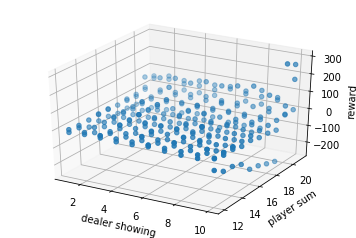

In [4]:
from mpl_toolkits.mplot3d import Axes3D
Axes3D = Axes3D  # pycharm auto import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = [k[1] for k in game_no.player_state_values.keys()]
y = [k[0] for k in game_no.player_state_values.keys()]
z = [v for v in game_no.player_state_values.values()]
ax.scatter(x, y, z)

ax.set_xlabel("dealer showing")
ax.set_ylabel("player sum")
ax.set_zlabel("reward")

In [5]:
usable_ace = {}
nonusable_ace = {}

for k, v in game_no.player_state_values.items():
    if k[2]:
        usable_ace[k] = v
    else:
        nonusable_ace[k] = v

Text(0.5,0,'reward')

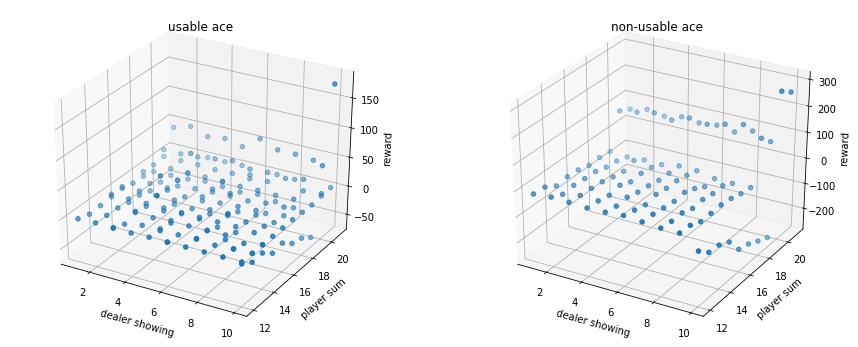

In [6]:
fig = plt.figure(figsize=[15, 6])

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x1 = [k[1] for k in usable_ace.keys()]
y1 = [k[0] for k in usable_ace.keys()]
z1 = [v for v in usable_ace.values()]
ax1.scatter(x1, y1, z1)

ax1.set_title("usable ace")
ax1.set_xlabel("dealer showing")
ax1.set_ylabel("player sum")
ax1.set_zlabel("reward")

x2 = [k[1] for k in nonusable_ace.keys()]
y2 = [k[0] for k in nonusable_ace.keys()]
z2 = [v for v in nonusable_ace.values()]
ax2.scatter(x2, y2, z2)

ax2.set_title("non-usable ace")
ax2.set_xlabel("dealer showing")
ax2.set_ylabel("player sum")
ax2.set_zlabel("reward")

## Win and Loss Probabilities

In [7]:
print("Win probability: ", game_no.player_win/10000.0)

Win probability:  0.3027


In [8]:
print("Loss probability: ", game_no.player_draw/10000.0)

Loss probability:  0.2241


## Play BlackJack with only One Ace available to each player

In [9]:
class BlackJack_Only_One_Ace:
    def __init__(self):
        self.player_win = 0
        self.player_draw = 0
        self.player_states = []
        self.player_state_values = {}
        self.showCard = 0
        
    def dealCards(self):
        return random.choice(list(range(1,11))+[10, 10, 10])
    
    def cal_val(self, value, usable_ace, is_player, first_turn = False):
        drawn_card = self.dealCards()
        value += drawn_card
        if drawn_card == 1:
            usable_ace = True
            if first_turn:
                value += 10
            
        if is_player and (value <= 21 and value >= 12):
            self.player_states.append((value, self.showCard, usable_ace))
    
        return value, usable_ace
 
    def policy(self, value, usable_ace, hit_value, is_player):
        
        if value >= hit_value and value <= 21 and is_player:
            self.player_states.append((value, self.showCard, usable_ace))
        
        while value < hit_value:
            value, usable_ace = self.cal_val(value, usable_ace, is_player)
#             print(value, usable_ace)
        
        while value > 21 and usable_ace:
            value -= 10
            usable_ace = False
#             print(value, usable_ace)
            while value < hit_value:
                value, usable_ace = self.cal_val(value, usable_ace, is_player)
#                 print(value, usable_ace)

        return value
    
    def giveReward(self, player_value, dealer_value):
        last_state = self.player_states[-1]
        if player_value > 21:
            if dealer_value > 21:
                self.player_draw += 1
            else:
                self.player_state_values[last_state] += -1
        elif dealer_value > 21:
            self.player_state_values[last_state] += 1
            self.player_win += 1
        elif player_value > dealer_value:
            self.player_state_values[last_state] += 1
            self.player_win += 1
        elif player_value == dealer_value:
            self.player_draw += 1
        else:
            self.player_state_values[last_state] += -1   
            
#         print(last_state)
#         print(self.player_state_values[last_state])
        
    def play(self, steps):
        player_hit_value = 20
        dealer_hit_value = 17
        
        for i in range(steps):
            if i % 1000 == 0:
                print("Round ", i, " done!")
        
            player_value = 0
            dealer_value= 0
            player_usable_ace = False
            dealer_usable_ace = False

            
            dealer_value, dealer_usable_ace = self.cal_val(dealer_value, dealer_usable_ace, is_player = False)
#             print(dealer_value, dealer_usable_ace)
            self.showCard = dealer_value
#             print(self.showCard)

            for i in range(2):
                player_value, player_usable_ace = self.cal_val(player_value, player_usable_ace, is_player = True, first_turn = True)
#                 print(player_value, player_usable_ace)
            
            if player_usable_ace:
                    player_value += 10

            player_value = self.policy(player_value, player_usable_ace, player_hit_value, is_player = True)
#             print(player_value)
            dealer_value = self.policy(dealer_value, dealer_usable_ace, dealer_hit_value, is_player = False)
#             print(dealer_value)

            for state in self.player_states:
                self.player_state_values[state] = 0 if self.player_state_values.get(state) is None else self.player_state_values.get(state)

            self.giveReward(player_value, dealer_value)

In [10]:
game = BlackJack_Only_One_Ace()
game.play(10000)

Round  0  done!
Round  1000  done!
Round  2000  done!
Round  3000  done!
Round  4000  done!
Round  5000  done!
Round  6000  done!
Round  7000  done!
Round  8000  done!
Round  9000  done!


## Visualize the Value Function

Text(0.5,0,'reward')

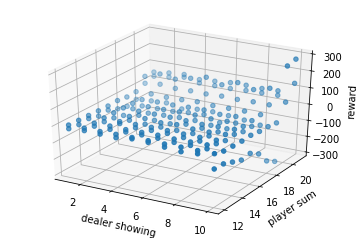

In [11]:
from mpl_toolkits.mplot3d import Axes3D
Axes3D = Axes3D  # pycharm auto import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = [k[1] for k in game.player_state_values.keys()]
y = [k[0] for k in game.player_state_values.keys()]
z = [v for v in game.player_state_values.values()]
ax.scatter(x, y, z)

ax.set_xlabel("dealer showing")
ax.set_ylabel("player sum")
ax.set_zlabel("reward")

In [12]:
usable_ace = {}
nonusable_ace = {}

for k, v in game.player_state_values.items():
    if k[2]:
        usable_ace[k] = v
    else:
        nonusable_ace[k] = v

Text(0.5,0,'reward')

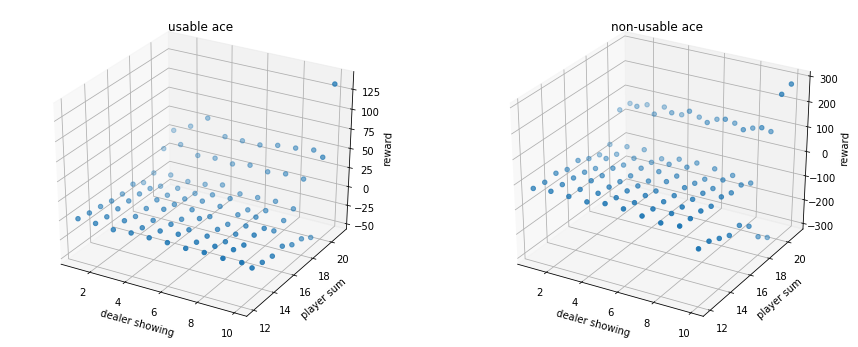

In [13]:
fig = plt.figure(figsize=[15, 6])

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x1 = [k[1] for k in usable_ace.keys()]
y1 = [k[0] for k in usable_ace.keys()]
z1 = [v for v in usable_ace.values()]
ax1.scatter(x1, y1, z1)

ax1.set_title("usable ace")
ax1.set_xlabel("dealer showing")
ax1.set_ylabel("player sum")
ax1.set_zlabel("reward")

x2 = [k[1] for k in nonusable_ace.keys()]
y2 = [k[0] for k in nonusable_ace.keys()]
z2 = [v for v in nonusable_ace.values()]
ax2.scatter(x2, y2, z2)

ax2.set_title("non-usable ace")
ax2.set_xlabel("dealer showing")
ax2.set_ylabel("player sum")
ax2.set_zlabel("reward")

## Win and Loss Probabilities

In [14]:
print("Win probability: ", game.player_win/10000.0)

Win probability:  0.2878


In [15]:
print("Loss probability: ", game.player_draw/10000.0)

Loss probability:  0.2344


## Conclusion

Having a usable ace increases the chances of winning the game (obvious).  If multiple aces are allowed, the range of rewards in general increase, as can be seen from the graphs of usable ace for the two cases.